### Import all the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
!pip install torch-summary==1.4.4 # for DenseNet121
from torchvision import models
from torchsummary import summary

import numpy as np 
from matplotlib import pyplot as plt 
import matplotlib.ticker as mticker

import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Preprocessing the Images

In [3]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def check_image_path(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

def random_brightness_contrast(image, alpha_range=(0.8, 1.2), beta_range=(-20, 20)):
    alpha = random.uniform(*alpha_range)  # Random contrast factor
    beta = random.randint(*beta_range)  # Random brightness factor
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):

    # Convert to grayscale for CLAHE
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_image = clahe.apply(gray_image)
    
    # Convert back to 3-channel format for consistency
    enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    return enhanced_image_rgb

def display_image_comparison(original_image, enhanced_image):
    # Plotting the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    # Enhanced Image
    axes[1].imshow(enhanced_image)
    axes[1].set_title("Image after CLAHE")
    axes[1].axis('off')  # Hide axes

    # Show the plot
    plt.show()

def read_xray_images(directory_path, img_height, img_width, augmentation=False, normalize=False, apply_clahe_flag=True, display_comparison=False):
    datax = [] 
    datay = [] 

    sub_directories = os.listdir(directory_path)

    for sub_dir in sub_directories: 
        sub_dir_path = os.path.join(directory_path, sub_dir)

        correct_image_filepaths = check_image_path(sub_dir_path)

        for fpath in correct_image_filepaths:  # Loop through the image file paths
            image = cv2.imread(fpath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_width, img_height))

            if apply_clahe_flag:
                enhanced_image = apply_clahe(image)
        

            if augmentation:
                image = random_brightness_contrast(image)
                if random.random() < 0.5:  # 50% chance to rotate
                    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

            if normalize:
                image = image / 255.0  # Normalize pixel values to [0, 1]

            if display_comparison:
                display_image_comparison(image,enhanced_image)

            datax.append(image)
            datay.append(sub_dir)

    return np.array(datax), np.array(datay)

### Download pre-trained model

In [4]:
vgg19_model = models.vgg19(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 205MB/s] 


### Model architecture

In [5]:
vgg19_model = vgg19_model.to(device)
print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Summarize model

In [6]:
summary(vgg19_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

### Model layers and their child modules

In [7]:
for name, module in vgg19_model.named_modules():
    print(name)


features
features.0
features.1
features.2
features.3
features.4
features.5
features.6
features.7
features.8
features.9
features.10
features.11
features.12
features.13
features.14
features.15
features.16
features.17
features.18
features.19
features.20
features.21
features.22
features.23
features.24
features.25
features.26
features.27
features.28
features.29
features.30
features.31
features.32
features.33
features.34
features.35
features.36
avgpool
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5
classifier.6


In [8]:
print(f"---Main modules---:")
for name, module in vgg19_model.named_children():
    print(name)

# we are interested in the features module since it contains the conv layers we want to unfreeze
print(f"---Child Modules for the 'features' module")
for name, module in vgg19_model.named_children():
    if name == "features":
        for n, m in module.named_children():
            print(n)

---Main modules---:
features
avgpool
classifier
---Child Modules for the 'features' module
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


In [9]:
for param in vgg19_model.parameters():
    param.requires_grad = False

### Flatten outputs from the Convolutional base networks and remove the Linear layers

In [10]:
vgg19_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
vgg19_model.classifier = nn.Flatten()
summary(vgg19_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

### Unfreeze the layers you want for fine-tuning

In [11]:
for param in vgg19_model.features[34:].parameters():
    param.requires_grad = True

In [12]:
summary(vgg19_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [13]:
img_height, img_width = 224, 224 
train_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Training"
validation_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Validation"
test_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Testing"

In [14]:
train_data_dir = train_data_dir
x_train, y_train = read_xray_images(train_data_dir, img_height, img_width, augmentation=True)

In [15]:
x_train.shape, y_train.shape

((60, 224, 224, 3), (60,))

In [16]:
validation_data_dir = validation_data_dir
x_val, y_val = read_xray_images(validation_data_dir, img_height, img_width, augmentation=True)

### Display Sample Images

Class labels sampled: ['Cardiomegaly' 'Atelectasis']


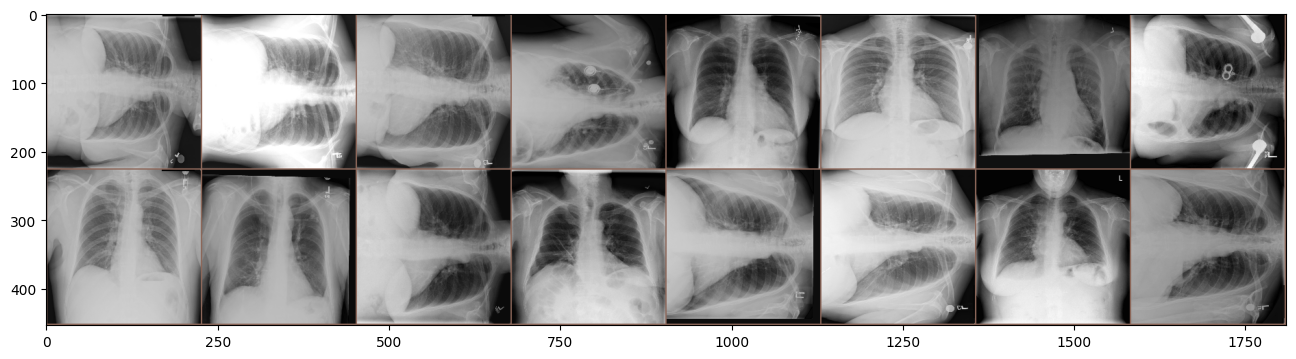

In [17]:
import sys

sys.path.append('/kaggle/input/myscripts/tensorflow2/default/1')

import prototypical_network
import train_and_evaluation

n_way = 2     
n_support = 5 
n_query = 3   
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_train, y_train)
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

### Train a Prototypical Network using a fine-tuned base model

In [18]:
import sys

sys.path.append('/kaggle/input/myscripts/tensorflow2/default/1')

import prototypical_network
import train_and_evaluation


model = prototypical_network.ProtoNet(vgg19_model, device)
model.to(device)

basic_learning_rate = 0.0005

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       
n_support = 3   
n_query = 20

validation_episodes = 20
train_episodes = 20

max_epoch = 20

filename = "vgg19_model_train-best-few-shot-model-2-way-3-shot.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)

average_train_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)
average_validation_accuracy = sum(validation_accuracy_list) / len(validation_accuracy_list)

# Print out the average accuracies and losses (as percentage)
print(f"Average Training Accuracy: {average_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {average_validation_accuracy:.2f}%")

Start training: 


Epoch 1 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1
	Train Loss: 2.153 | Train Acc: 56.50%
	 Val. Loss: 2.125 | Val. Acc: 54.13%


Epoch 2 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 2
	Train Loss: 1.320 | Train Acc: 56.38%
	 Val. Loss: 1.999 | Val. Acc: 52.88%


Epoch 3 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 3
	Train Loss: 1.264 | Train Acc: 59.25%
	 Val. Loss: 1.875 | Val. Acc: 49.38%


Epoch 4 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 4
	Train Loss: 1.124 | Train Acc: 61.88%
	 Val. Loss: 1.834 | Val. Acc: 52.88%


Epoch 5 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 5
	Train Loss: 1.058 | Train Acc: 62.38%
	 Val. Loss: 1.709 | Val. Acc: 53.75%


Epoch 6 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 6
	Train Loss: 0.940 | Train Acc: 64.50%
	 Val. Loss: 1.739 | Val. Acc: 51.13%


Epoch 7 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 7
	Train Loss: 1.107 | Train Acc: 62.88%
	 Val. Loss: 1.509 | Val. Acc: 48.50%


Epoch 8 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 8
	Train Loss: 1.071 | Train Acc: 63.75%
	 Val. Loss: 1.849 | Val. Acc: 48.63%


Epoch 9 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 9
	Train Loss: 1.244 | Train Acc: 58.38%
	 Val. Loss: 1.611 | Val. Acc: 50.38%


Epoch 10 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 10
	Train Loss: 1.023 | Train Acc: 64.63%
	 Val. Loss: 1.774 | Val. Acc: 51.25%


Epoch 11 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 11
	Train Loss: 0.974 | Train Acc: 64.00%
	 Val. Loss: 1.877 | Val. Acc: 50.13%


Epoch 12 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 12
	Train Loss: 1.007 | Train Acc: 60.13%
	 Val. Loss: 1.629 | Val. Acc: 55.13%


Epoch 13 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 13
	Train Loss: 1.028 | Train Acc: 61.63%
	 Val. Loss: 1.802 | Val. Acc: 51.75%


Epoch 14 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 14
	Train Loss: 1.040 | Train Acc: 63.50%
	 Val. Loss: 1.714 | Val. Acc: 49.00%


Epoch 15 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 15
	Train Loss: 1.019 | Train Acc: 64.25%
	 Val. Loss: 1.703 | Val. Acc: 52.38%


Epoch 16 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 16
	Train Loss: 0.946 | Train Acc: 64.75%
	 Val. Loss: 1.801 | Val. Acc: 52.88%


Epoch 17 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 17
	Train Loss: 1.015 | Train Acc: 64.63%
	 Val. Loss: 1.702 | Val. Acc: 50.63%


Epoch 18 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 18
	Train Loss: 1.058 | Train Acc: 62.25%
	 Val. Loss: 1.748 | Val. Acc: 49.50%


Epoch 19 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 19
	Train Loss: 0.978 | Train Acc: 64.75%
	 Val. Loss: 1.604 | Val. Acc: 52.50%


Epoch 20 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 20
	Train Loss: 1.046 | Train Acc: 63.63%
	 Val. Loss: 1.690 | Val. Acc: 50.25%
Average Training Accuracy: 0.62%
Average Validation Accuracy: 0.51%


In [19]:
img_height, img_width = 224, 224
data_dir = test_data_dir
x_test, y_test = read_xray_images(data_dir, img_height, img_width, augmentation=False)

### 2 Way 3 Shot VGG19 Testing

In [20]:
prototypical_model = prototypical_network.ProtoNet(vgg19_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 20

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 1.385, Accuracy: 0.45
Episode: 100 ---> Loss: 0.603, Accuracy: 0.82
Episode: 200 ---> Loss: 0.767, Accuracy: 0.70
Episode: 300 ---> Loss: 0.249, Accuracy: 0.90
Episode: 400 ---> Loss: 1.023, Accuracy: 0.80
Episode: 500 ---> Loss: 1.774, Accuracy: 0.65
Episode: 600 ---> Loss: 0.780, Accuracy: 0.85
Episode: 700 ---> Loss: 0.701, Accuracy: 0.75
Episode: 800 ---> Loss: 2.602, Accuracy: 0.55
Episode: 900 ---> Loss: 0.690, Accuracy: 0.70
Episode: 1000 ---> Loss: 0.959, Accuracy: 0.68
Episode: 1100 ---> Loss: 1.106, Accuracy: 0.65
Episode: 1200 ---> Loss: 1.838, Accuracy: 0.60
Episode: 1300 ---> Loss: 0.228, Accuracy: 0.95
Episode: 1400 ---> Loss: 0.340, Accuracy: 0.85
Episode: 1500 ---> Loss: 0.767, Accuracy: 0.73
Episode: 1600 ---> Loss: 0.448, Accuracy: 0.82
Episode: 1700 ---> Loss: 0.526, Accuracy: 0.80
Episode: 1800 ---> Loss: 0.573, Accuracy: 0.78
Episode: 1900 ---> Loss: 0.349, Accuracy: 0.82
Episode: 2000 ---> Loss: 0.7

### 2 Way 3 Shot VGG19 Prediction

Class labels sampled: ['Effusion' 'Pneumonia']
{'loss': 2.113722801208496, 'acc': 0.5250000357627869, 'y_hat': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]],
       device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]])}


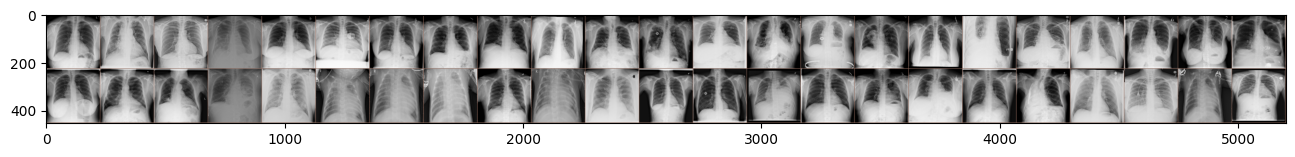

In [21]:
prototypical_model.to(device)
n_way = 2
n_support = 3
n_query = 20 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

### Classification Report

In [22]:
from sklearn.metrics import classification_report


y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    Effusion       0.52      0.70      0.60        20
   Pneumonia       0.54      0.35      0.42        20

    accuracy                           0.53        40
   macro avg       0.53      0.52      0.51        40
weighted avg       0.53      0.53      0.51        40



### ROC Curve

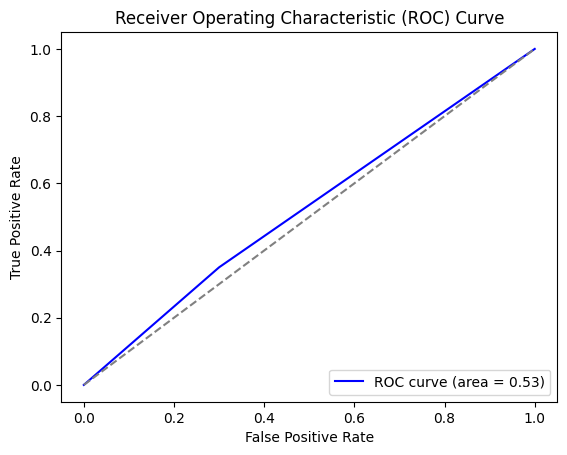

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_true_flat = results["y_true"].flatten() 
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

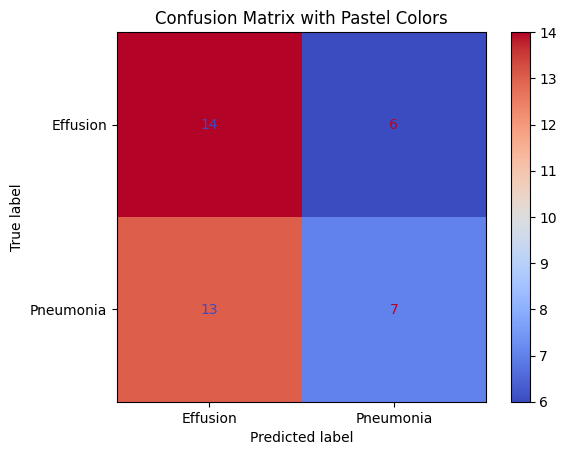

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)


cmap = plt.cm.coolwarm


disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap)


plt.title("Confusion Matrix with Pastel Colors")
plt.grid(False)  
plt.show()


### 2 Way 5 Shot VGG19 Testing

In [25]:
prototypical_model = prototypical_network.ProtoNet(vgg19_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 20

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 0.704, Accuracy: 0.68
Episode: 100 ---> Loss: 0.305, Accuracy: 0.90
Episode: 200 ---> Loss: 0.369, Accuracy: 0.78
Episode: 300 ---> Loss: 0.339, Accuracy: 0.78
Episode: 400 ---> Loss: 0.513, Accuracy: 0.82
Episode: 500 ---> Loss: 1.015, Accuracy: 0.57
Episode: 600 ---> Loss: 1.229, Accuracy: 0.65
Episode: 700 ---> Loss: 0.679, Accuracy: 0.82
Episode: 800 ---> Loss: 1.421, Accuracy: 0.55
Episode: 900 ---> Loss: 1.529, Accuracy: 0.50
Episode: 1000 ---> Loss: 1.248, Accuracy: 0.68
Episode: 1100 ---> Loss: 0.715, Accuracy: 0.62
Episode: 1200 ---> Loss: 1.042, Accuracy: 0.53
Episode: 1300 ---> Loss: 0.170, Accuracy: 0.98
Episode: 1400 ---> Loss: 1.279, Accuracy: 0.70
Episode: 1500 ---> Loss: 0.444, Accuracy: 0.82
Episode: 1600 ---> Loss: 0.722, Accuracy: 0.80
Episode: 1700 ---> Loss: 1.147, Accuracy: 0.62
Episode: 1800 ---> Loss: 0.378, Accuracy: 0.85
Episode: 1900 ---> Loss: 0.748, Accuracy: 0.78
Episode: 2000 ---> Loss: 1.0

### 2 Way 3 Shot VGG19 Prediction

Class labels sampled: ['Covid19' 'Effusion']
{'loss': 0.600485622882843, 'acc': 0.8000000715255737, 'y_hat': tensor([[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]])}


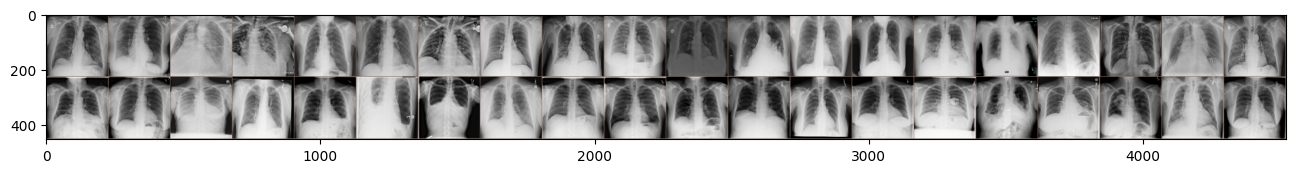

In [26]:
prototypical_model.to(device)
n_way = 2
n_support = 5
n_query = 15 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

### Classification Report

In [27]:
from sklearn.metrics import classification_report


y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     Covid19       0.80      0.80      0.80        15
    Effusion       0.80      0.80      0.80        15

    accuracy                           0.80        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.80      0.80      0.80        30



### ROC Curve

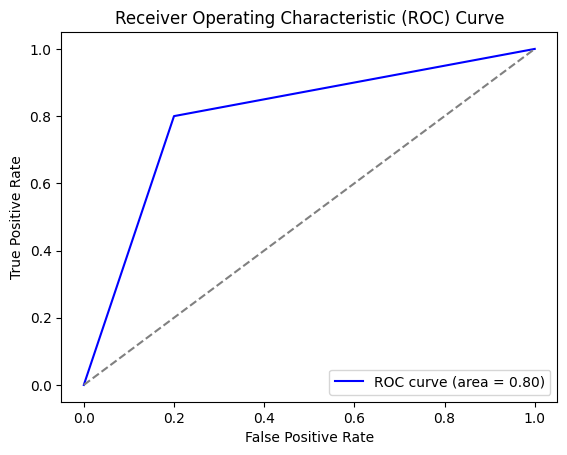

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_true_flat = results["y_true"].flatten()  
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

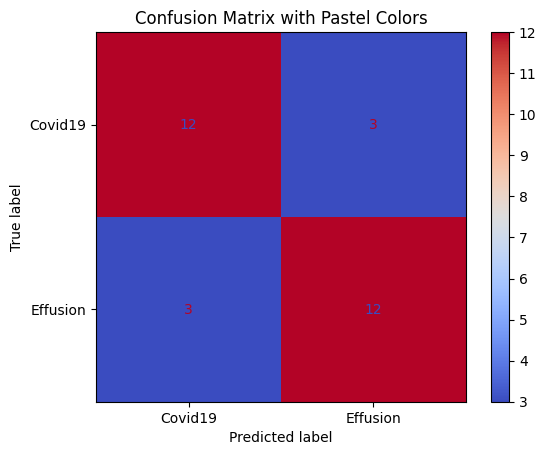

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)


cmap = plt.cm.coolwarm


disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap)


plt.title("Confusion Matrix with Pastel Colors")
plt.grid(False)  
plt.show()

## 3 Way 5 Shot VGG19 Testing

In [30]:
prototypical_model = prototypical_network.ProtoNet(vgg19_model, device)
prototypical_model.to(device)

n_way = 3
n_support = 5
n_query = 25

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 0.899, Accuracy: 0.69
Episode: 100 ---> Loss: 1.973, Accuracy: 0.61
Episode: 200 ---> Loss: 0.932, Accuracy: 0.65
Episode: 300 ---> Loss: 0.974, Accuracy: 0.61
Episode: 400 ---> Loss: 1.421, Accuracy: 0.64
Episode: 500 ---> Loss: 1.551, Accuracy: 0.43
Episode: 600 ---> Loss: 1.407, Accuracy: 0.65
Episode: 700 ---> Loss: 1.036, Accuracy: 0.65
Episode: 800 ---> Loss: 1.150, Accuracy: 0.60
Episode: 900 ---> Loss: 1.465, Accuracy: 0.60
Episode: 1000 ---> Loss: 1.414, Accuracy: 0.65
Episode: 1100 ---> Loss: 1.274, Accuracy: 0.55
Episode: 1200 ---> Loss: 1.140, Accuracy: 0.49
Episode: 1300 ---> Loss: 1.034, Accuracy: 0.57
Episode: 1400 ---> Loss: 0.788, Accuracy: 0.68
Episode: 1500 ---> Loss: 2.210, Accuracy: 0.57
Episode: 1600 ---> Loss: 2.636, Accuracy: 0.60
Episode: 1700 ---> Loss: 2.272, Accuracy: 0.59
Episode: 1800 ---> Loss: 1.573, Accuracy: 0.56
Episode: 1900 ---> Loss: 1.023, Accuracy: 0.61
Episode: 2000 ---> Loss: 1.0

### 3 Way 5 Shot VGG19 Prediction

Class labels sampled: ['Covid19' 'Pneumonia' 'Effusion']
{'loss': 3.148519515991211, 'acc': 0.5200000405311584, 'y_hat': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         2],
        [0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0,
         2],
        [0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0,
         2]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2]]), 'y_pred': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2],
       [0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2,
        0, 0, 2],
       [0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2,
        0, 0, 2]])}


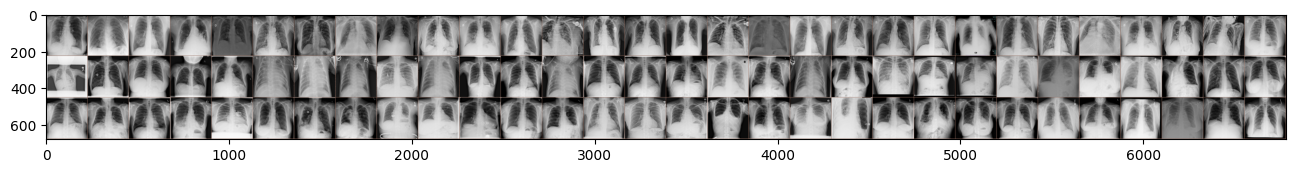

In [31]:
prototypical_model.to(device)
n_way = 3
n_support = 5
n_query = 25 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

### Classification Report

In [32]:
from sklearn.metrics import classification_report


y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     Covid19       0.49      0.92      0.64        25
   Pneumonia       0.50      0.04      0.07        25
    Effusion       0.58      0.60      0.59        25

    accuracy                           0.52        75
   macro avg       0.52      0.52      0.43        75
weighted avg       0.52      0.52      0.43        75



### Confusion Matrix

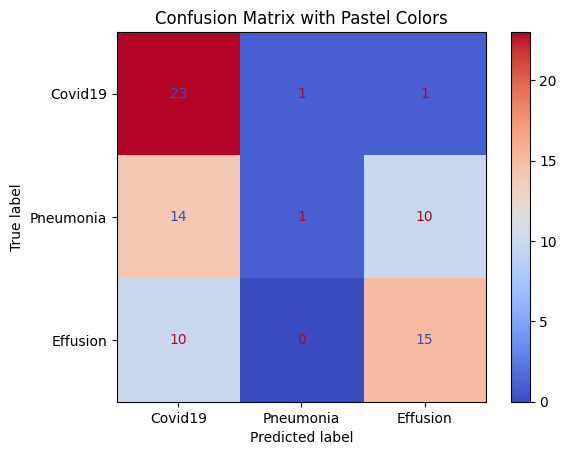

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)


cmap = plt.cm.coolwarm 


disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap)


plt.title("Confusion Matrix with Pastel Colors")
plt.grid(False)  
plt.show()

### ROC Curve

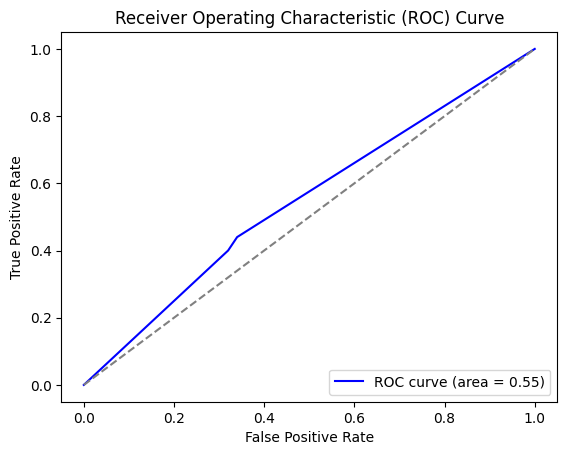

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_true_flat = results["y_true"].flatten()  
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()